In [54]:
import numpy as np
import matplotlib.pyplot as plt

In [55]:
def read_audio(file: str):
    data = np.load(file)
    cutoff_point = np.std(data) * 1.7
    return data

(112640,)
16385384.627111074


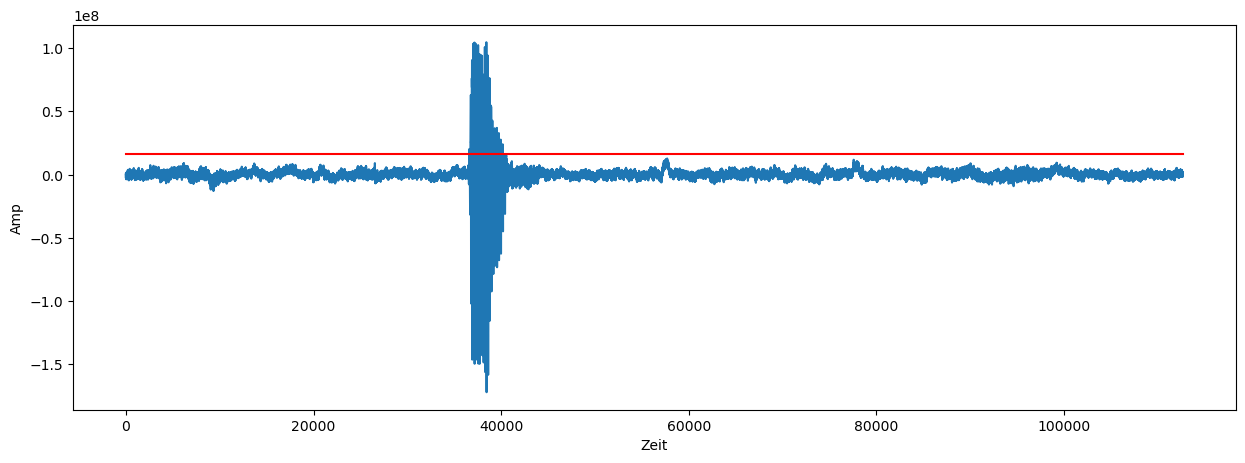

In [56]:
kevin_hoch = read_audio("./aufnahme/kevin/hoch/2023-06-05_15-36-32.npy")
print(kevin_hoch.shape)

fig, ax = plt.subplots(figsize=(15,5))
ax.set_ylabel("Amp")
ax.set_xlabel("Zeit")

ax.plot(kevin_hoch)

cutoff_point = np.std(kevin_hoch) * 1.7
print(cutoff_point)

ax.plot([0,kevin_hoch.size], [cutoff_point, cutoff_point], color="r")